# 47_전이학습과 미세조정 - 전이학습

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [8]:
## 원본 파일이 이동하여서 setattr 설정을 추가하여 받아옴
## https://github.com/tensorflow/datasets/issues/3918  참고

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
            # train data : 80%
                            # validation data : 10%
                                                # test data : 10%
    with_info=True,
    as_supervised=True,
                # True : 데이터가 라벨과 함께 Tuple 형태로 저장된다.
)

# https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

1


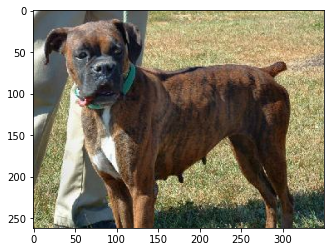

In [9]:
# 데이터 구경하기
for image, label in raw_train.take(1):
    plt.imshow(image)
    print(label.numpy())

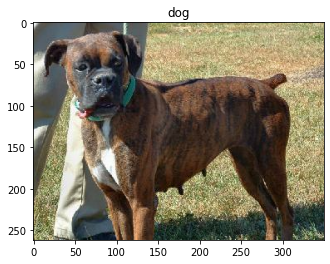

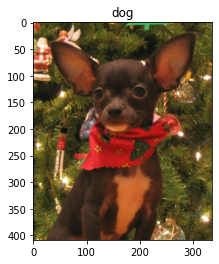

In [10]:
# 메타 정보에서 라벨 이름 가져와서 두 개만
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [11]:
# 이미지 전처리 함수
IMG_SIZE = 160
            # 모든 이미지는 160 * 160 으로

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
                    # 0 ~ 255 사이의 중간 127.5 로 나누고
                    # 0 ~ 2 사이의 값이 된다.
                            # 1을 뺐기 때문에, 
                            # -1 ~ 1 사이에 위치 : 중간을 0으로 잡는 것.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [14]:
# map 함수를 이용해서 빠르게 적용
train = raw_train.map(format_example)
validation  = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [15]:
# batch_size 적용, shuffle
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches  = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
# 확인
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# MobileNet V2 모델

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                                        # 출력단 : 원래 학습되어있던 클래스의 숫자만큼 사이즈를 잡게 될텐데
                                                        # 이를 False 시킨다. 즉 거부함.
                                                        # 우리가 쓸 데이터의 사이즈는 다르기 때문에 설정
                                               weights= 'imagenet')
                                                # weights : imagenet 에 사용된 가중치를 가져옴

9420800/9406464 [==============================] - 0s 0us/step


> - 이 모델은 1.4M 이미지와 1000개의 Class 로 구성된 대규모 데이터셋인 `ImageNet` 데이터 셋을 사용해 사전 훈련된 모델
> - 먼저 기능 추출에 사용할 `MobileNet V2` 층을 선택
> - flatten 연산을 하기 전에 `맨 아래층을 가지고 진행` (병목층)
> - `include_top = False` 로 지정하면 맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 이상적

In [19]:
feature_batch = base_model(image_batch)
            # Top 을 빼고 불러옴
print(feature_batch.shape)

(32, 5, 5, 1280)


> 이 특징 추출기는 각 `160 * 160 * 3` 이미지를 `5 * 5 * 1280` 개의 특징 블록으로 변환\
> Tensorflow 의 채널은 맨뒤 // PyTorch의 채널은 맨 앞

In [20]:
# 모델 확인하기
base_model.trainable = False

In [21]:
base_model.summary()

# trainable > False : 가중치를 건들지 않겠다는 설정

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

# Global Average Pooling 2D layer

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


> `GlobalAveragePooling2D layer`를 사용하여 특징을 이미지 한개 당 `1280개의 요소 벡터`로 변환

# Dense layer 를 사용하여 특징을 이미지당 단일 예측

In [24]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [25]:
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.5494136 ],
       [-0.7871235 ],
       [-0.9935823 ],
       [-1.7217543 ],
       [-1.0798095 ],
       [-1.9095389 ],
       [-1.9969383 ],
       [-0.4259435 ],
       [-1.3820741 ],
       [-1.8037167 ],
       [-0.42388836],
       [-2.4321496 ],
       [ 0.19062835],
       [-0.91740566],
       [-1.4534222 ],
       [-2.5139902 ],
       [-1.8430864 ],
       [-0.6899034 ],
       [-1.3145885 ],
       [-1.6105582 ],
       [-1.9657847 ],
       [-0.15137291],
       [-1.9203126 ],
       [-1.5969754 ],
       [-0.77249455],
       [-2.3345451 ],
       [ 0.4595403 ],
       [-0.49257416],
       [-0.247132  ],
       [-0.2888239 ],
       [-0.5767837 ],
       [-2.2457666 ]], dtype=float32)>

> 양수는 클래스 1을 예측하고, 음수는 클래스 0을 예측

# 전체 모델 구성

In [26]:
model = tf.keras.Sequential([
                             base_model,        # 원래 mobileNetV2
                             global_average_layer,
                             prediction_layer
])

In [27]:
# 모델 컴파일
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
# 아무런 학습을 하지 않은 현재의 성능
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 6s 57ms/step - loss: 0.8961 - accuracy: 0.4875


In [30]:
# 학습
history = model.fit(train_batches,
                    epochs = initial_epochs,
                    validation_data = validation_batches)

Epoch 1/10
582/582 [==============================] - 61s 95ms/step - loss: 0.2214 - accuracy: 0.8981 - val_loss: 0.0852 - val_accuracy: 0.9725
Epoch 2/10
582/582 [==============================] - 54s 90ms/step - loss: 0.0727 - accuracy: 0.9748 - val_loss: 0.0611 - val_accuracy: 0.9781
Epoch 3/10
582/582 [==============================] - 69s 116ms/step - loss: 0.0590 - accuracy: 0.9796 - val_loss: 0.0539 - val_accuracy: 0.9789
Epoch 4/10
582/582 [==============================] - 64s 106ms/step - loss: 0.0532 - accuracy: 0.9809 - val_loss: 0.0499 - val_accuracy: 0.9802
Epoch 5/10
582/582 [==============================] - 50s 83ms/step - loss: 0.0498 - accuracy: 0.9814 - val_loss: 0.0475 - val_accuracy: 0.9819
Epoch 6/10
582/582 [==============================] - 49s 82ms/step - loss: 0.0473 - accuracy: 0.9821 - val_loss: 0.0463 - val_accuracy: 0.9819
Epoch 7/10
582/582 [==============================] - 49s 81ms/step - loss: 0.0457 - accuracy: 0.9828 - val_loss: 0.0451 - val_accurac

> - trainable weights가 1200여개 뿐이지만 연산은 전체를 다해야하기 때문에 만만한 시간은 아님
> - 그러나 mobileNet 전체를 다시 학습하는 것 보다는 훨씬 좋다.

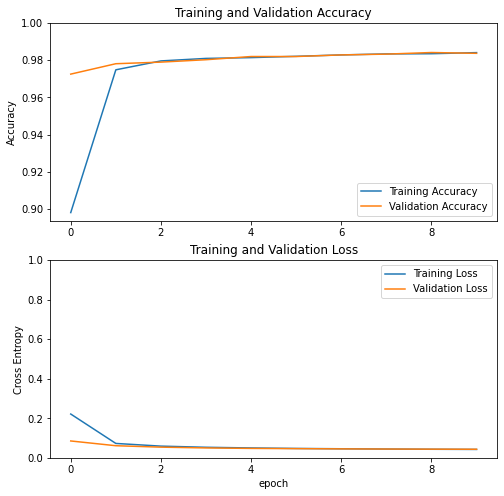

In [32]:
# acc 확인하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
# 모두 trainable
base_model.trainable = True
print('Number of layers in the base model : ', len(base_model.layers))

Number of layers in the base model :  154


------------------------------------------
# 48_전이학습과 미세조정 - 미세조정

In [34]:
# 100번째 층부터 튜닝 가능하게 설정
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable= False

In [36]:
# 학습 비율 낮추기
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [38]:
# 총 20번의 epoch
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                                            # history : 0~ 10번까지 학습을 했고, 이어서 학습함을 의미함.
                         validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 58s 86ms/step - loss: 0.1283 - accuracy: 0.9527 - val_loss: 0.0815 - val_accuracy: 0.9789
Epoch 11/20
582/582 [==============================] - 52s 87ms/step - loss: 0.0728 - accuracy: 0.9714 - val_loss: 0.0512 - val_accuracy: 0.9832
Epoch 12/20
582/582 [==============================] - 51s 85ms/step - loss: 0.0510 - accuracy: 0.9801 - val_loss: 0.0472 - val_accuracy: 0.9828
Epoch 13/20
582/582 [==============================] - 50s 84ms/step - loss: 0.0413 - accuracy: 0.9841 - val_loss: 0.0460 - val_accuracy: 0.9824
Epoch 14/20
582/582 [==============================] - 51s 85ms/step - loss: 0.0328 - accuracy: 0.9878 - val_loss: 0.0462 - val_accuracy: 0.9832
Epoch 15/20
582/582 [==============================] - 51s 84ms/step - loss: 0.0256 - accuracy: 0.9901 - val_loss: 0.0489 - val_accuracy: 0.9832
Epoch 16/20
582/582 [==============================] - 51s 84ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.0504 - val_ac

In [39]:
# 최초 history에 최신 학습결과 추가
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

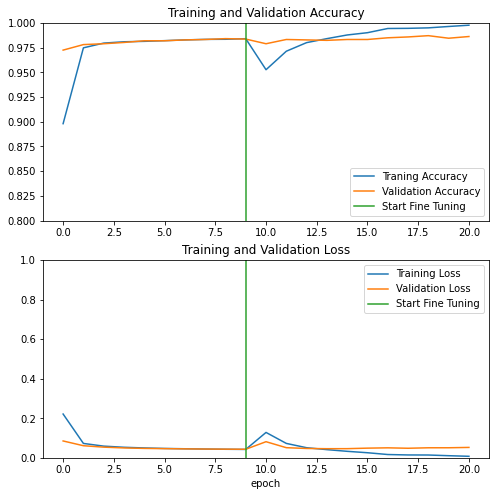

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Traning Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()